# Cas pratique ACP - Analyse de pays pour l'exportation de poissons

Données FAO 2016-2017 : 
- bilans alimentaires relatifs aux poissons pélagiques
- PIB et populations

http://www.fao.org/faostat/fr/#data

<img src="data/fao_logo.svg" width=150>

In [1]:
# pour evaluer temps de calcul
start_time <- Sys.time()

#Loading packages
library(dplyr)
library(data.table)
library(tidyr)
library(stringr)
library(FactoMineR)
library(factoextra)
library(missMDA)
library(corrplot)
library(gridExtra)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.89 loaded


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
# Fonctions pour notebook

# Parametrage pour lecture des csv
read_csv <- function(path) {
    df <- fread(path, stringsAsFactors=FALSE, encoding="UTF-8")
    return(df)
}

# Formattage des chaines de caractères
form <- function(x) {
    x <- tolower(x)
    x <- str_replace_all(x, " - ", "_")
    x <- str_replace_all(x, "é", "e")
    x <- str_replace_all(x, " ", "_")
    x <- str_replace_all(x, "\\(", "")
    x <- str_replace_all(x, "\\)", "")
    x <- str_replace_all(x, "/", "_")
    x <- str_replace_all(x, "\\.", "")
    x <- str_replace_all(x, "\\'", "")
    return(x)
}

# Nombre de doublons dans un dataframe
doublons <- function(df) {
    print(paste("Dimensions :", dim(df)[1], dim(df)[2], sep=" "))
    print(paste("Doublons : ", sum(duplicated(df))))
}

# Formattage noms de colonnes et contrôle doublons dataframe
check <- function(df) {
    names(df) <- form(names(df))
    doublons(df)
    return(df)
}

# Variation n et n-1
variation <- function(previous, present) {
    var <- if_else(previous == 0, 0, (present-previous)/previous)
    return(var)
}

## 1. Importation des données

In [3]:
# Chargement données FAO 2017
ba <- read_csv("data/FAOSTAT_data_6-27-2021_BA_PP.csv")
pib <- read_csv("data/FAOSTAT_data_6-27-2021_SA_PIB.csv")
pop <- read_csv("data/FAOSTAT_data_6-27-2021_POP.csv")

### 1.1 Desciption des bilans alimentaires

In [4]:
# Données bases alimentaires
ba <- check(ba)
head(ba, 2)

[1] "Dimensions : 3962 14"
[1] "Doublons :  0"


code_domaine,domaine,code_zone_fao,zone,code_element,element,code_produit,produit,code_annee,annee,unite,valeur,symbole,description_du_symbole
<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5511,Production,2763,Poissons Pelagiques,2016,2016,Milliers de tonnes,420.11,Im,Données de la FAO basées sur une méthodologie d'imputation
FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5511,Production,2763,Poissons Pelagiques,2017,2017,Milliers de tonnes,342.35,Im,Données de la FAO basées sur une méthodologie d'imputation


### 1.2 Description des PIB

In [5]:
# Données pib
pib <- check(pib)
head(pib, 2)

[1] "Dimensions : 372 15"
[1] "Doublons :  0"


code_domaine,domaine,code_zone_fao,zone,code_element,element,code_produit,produit,code_annee,annee,unite,valeur,symbole,description_du_symbole,note
<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<lgl>
FS,Données de la sécurité alimentaire,2,Afghanistan,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux constants de 2011)",2016,2016,I$,2200.8,X,Sources internationales sûres,NA
FS,Données de la sécurité alimentaire,2,Afghanistan,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux constants de 2011)",2017,2017,I$,2202.6,X,Sources internationales sûres,NA


### 1.3 Description des populations

In [6]:
# Donnée pop
pop <- check(pop)
head(pop, 2)

[1] "Dimensions : 474 15"
[1] "Doublons :  0"


code_domaine,domaine,code_zone_fao,zone,code_element,element,code_produit,produit,code_annee,annee,unite,valeur,symbole,description_du_symbole,note
<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2016,2016,1000 personnes,35383.03,X,Sources internationales sûres,
OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,36296.11,X,Sources internationales sûres,


### 1.4 Exclusion zone doublon

In [7]:
# Exclusion doublon chine 351
ba <- ba %>% filter(code_zone_fao != 351)
pib <- pib %>% filter(code_zone_fao != 351)
pop <- pop %>% filter(code_zone_fao != 351)

## 2. Création des variables
### 2.1 Extraction variable population 2017

In [8]:
vars_pop <- pop %>% 
    select(code_zone_fao, annee, valeur) %>% 
    pivot_wider(id_cols=code_zone_fao, names_from = annee, names_prefix = "pop_", values_from = valeur) %>%
    select(code_zone_fao, pop_2017)

head(vars_pop)

code_zone_fao,pop_2017
<int>,<dbl>
2,36296.113
202,57009.756
3,2884.169
4,41389.189
79,82658.409
6,77.001


### 2.2 Extraction variable PIB par habitant 2017

In [9]:
### Variables PIB
vars_pib <- pib %>%
    select(code_zone_fao, annee, valeur) %>% 
    pivot_wider(id_cols=code_zone_fao, names_from = annee, names_prefix = "pib_hab_", values_from = valeur) %>%
    select(code_zone_fao, pib_hab_2017)
    
head(vars_pib)

code_zone_fao,pib_hab_2017
<int>,<dbl>
2,2202.6
202,12703.4
3,13037.0
4,11550.5
79,53011.8
7,7310.9


### 2.3 Création des variables de bilans alimentaires

Elements disponibles par les bilans alimentaires :

In [10]:
# Formattage des noms de variables
ba <- ba %>% mutate(element = form(element))

# Variables disponibles
ba %>% select(element) %>% unique()

element
<chr>
production
importations_quantite
variation_de_stock
exportations_quantite
disponibilite_interieure
aliments_pour_animaux
autres_utilisations_non_alimentaire
nourriture
disponibilite_alimentaire_en_quantite_kg_personne_an


#### Formule d'égalité des bilans alimentaires 
#### <center>Disponibilité = Utilisation 
#### <center>Disponibilité = Production + Importation - exportation - variation de stock
#### <center>Utilisation =  Nourriture + aliments animaux + autres utilisations + semences

### 2.3.1 Statistiques par habitant

In [11]:
# Sélection des éléments de bilan
elts <- c("production",
          "importations_quantite",
          "exportations_quantite",
          "nourriture")

# Chiffres ramenés par habitant kg/hab
vars_ba <- ba %>%
    filter(annee == 2017) %>%
    filter(element %in% elts) %>%    
    mutate(element = sub("_\\w*", "", element)) %>%
    select(code_zone_fao, element, annee, valeur) %>%
    left_join(unique(select(vars_pop, code_zone_fao, pop_2017)), by = "code_zone_fao") %>%
    mutate(valeur=if_else(pop_2017==0, 0, valeur*1000/pop_2017)) %>%
    mutate(element=paste(element, "hab", sep="_")) %>%
    select(-pop_2017) %>%
    pivot_wider(id_cols=code_zone_fao, names_from = c(element, annee), values_from = valeur)

# Nouvelles variables
print(names(vars_ba))
vars_ba %>% head()

[1] "code_zone_fao"         "production_hab_2017"   "importations_hab_2017"
[4] "exportations_hab_2017" "nourriture_hab_2017"  


code_zone_fao,production_hab_2017,importations_hab_2017,exportations_hab_2017,nourriture_hab_2017
<int>,<dbl>,<dbl>,<dbl>,<dbl>
202,6.0051125,2.919500,5.57237958,2.910730
3,0.5755557,6.809587,4.01502131,3.307712
4,1.6588873,1.124931,0.03334204,2.750477
79,1.5796336,9.635801,8.56379900,2.488676
7,10.6134918,4.987798,0.97327792,12.507728
8,0.6287595,10.269738,0.00000000,10.793704


### 2.3.2 Ajout Pib par habitant

In [12]:
# Ajout nom du pays + pib par hab
df <- vars_ba %>%
    left_join(unique(select(ba, code_zone_fao, zone)), by="code_zone_fao") %>%
    relocate(zone) %>%
    left_join(unique(select(vars_pib, code_zone_fao, pib_hab_2017)), by="code_zone_fao") %>%
    select(-code_zone_fao)

head(df)

zone,production_hab_2017,importations_hab_2017,exportations_hab_2017,nourriture_hab_2017,pib_hab_2017
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afrique du Sud,6.0051125,2.919500,5.57237958,2.910730,12703.4
Albanie,0.5755557,6.809587,4.01502131,3.307712,13037.0
Algérie,1.6588873,1.124931,0.03334204,2.750477,11550.5
Allemagne,1.5796336,9.635801,8.56379900,2.488676,53011.8
Angola,10.6134918,4.987798,0.97327792,12.507728,7310.9
Antigua-et-Barbuda,0.6287595,10.269738,0.00000000,10.793704,19840.1


## 3. Revue des variables

In [13]:
# Summary et NAs
summary(df)
paste("NAs :", sum(is.na(df)), sep=" ")

     zone           production_hab_2017 importations_hab_2017
 Length:174         Min.   :   0.0000   Min.   :  0.0013     
 Class :character   1st Qu.:   0.6983   1st Qu.:  1.1342     
 Mode  :character   Median :   4.8348   Median :  3.8531     
                    Mean   :  61.2737   Mean   : 14.5683     
                    3rd Qu.:  19.0965   3rd Qu.:  8.5021     
                    Max.   :1423.9600   Max.   :795.7020     
                    NA's   :38                               
 exportations_hab_2017 nourriture_hab_2017  pib_hab_2017     
 Min.   :   0.0000     Min.   : 0.00462    Min.   :   912.8  
 1st Qu.:   0.0242     1st Qu.: 1.93464    1st Qu.:  4858.0  
 Median :   0.3503     Median : 4.12544    Median : 13037.0  
 Mean   :  37.4344     Mean   : 7.29920    Mean   : 20067.8  
 3rd Qu.:   5.9367     3rd Qu.: 9.52194    3rd Qu.: 28786.0  
 Max.   :2115.9949     Max.   :82.55406    Max.   :126918.0  
 NA's   :4                                 NA's   :7         

[1] "NAs : 49"

### 3.1 Valeurs extremes et Polynésie Française

In [14]:
# Check des pays avec des valeurs extremes
df %>% filter(production_hab_2017 > 1000 |
              importations_hab_2017 > 500 |
              exportations_hab_2017 > 1000 |
              nourriture_hab_2017 > 50
               )
#Check PF
df %>% filter(zone == "Polynésie française")

zone,production_hab_2017,importations_hab_2017,exportations_hab_2017,nourriture_hab_2017,pib_hab_2017
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islande,1411.3932,104.547643,1455.1142,44.767684,55562.4
Kiribati,1391.3173,11.300128,777.1685,56.062650,2240.5
Maldives,284.7088,5.721170,180.2773,82.554059,17988.7
Saint-Kitts-et-Nevis,1423.9600,1.729273,0.0000,2.882121,25355.5
Seychelles,1386.4631,795.702047,2115.9949,34.537120,27242.7


zone,production_hab_2017,importations_hab_2017,exportations_hab_2017,nourriture_hab_2017,pib_hab_2017
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Polynésie française,28.82993,8.656221,3.476976,26.40329,NA


### 3.2 Suppression des outliers pour améliorer le graphique de présentation

In [15]:
# Calcul de seuil / écart type
seuil_outliers <- function(x, ecart_types=3) {
    seuil <- mean(x, na.rm=TRUE) + ecart_types * sd(x, na.rm=TRUE)
    return(seuil)
}

Seuil pour outliers à 3 écart type.

In [16]:
# Seuils par colonnes
cols_numeric <- df %>% select_if(is.numeric) %>% colnames()

seuils <-df %>% 
    select(all_of(cols_numeric)) %>%
    summarise_all(seuil_outliers, 3) %>%
    t() %>%
    as.data.frame() %>%
    add_rownames() %>%
    rename(var=rowname, seuil=V1)

seuils

Warning message:
"`add_rownames()` was deprecated in dplyr 1.0.0.
Please use `tibble::rownames_to_column()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


var,seuil
<chr>,<dbl>
production_hab_2017,778.9492
importations_hab_2017,209.1415
exportations_hab_2017,654.9046
nourriture_hab_2017,37.2680
pib_hab_2017,81919.7072


In [17]:
# Filtrage des pays seuils
df_cleaned <- df

for (col in seuils$var) {
    seuil <- seuils %>% filter(var==col) %>% select(seuil) %>% as.numeric()
    df_cleaned <- df_cleaned %>% filter((!get(col) > seuil) | is.na(get(col)))
}

dim(df_cleaned)

[1] 166   6

In [18]:
# Liste des pays exclus / outliers
df$zone[!df$zone %in% df_cleaned$zone]

[1] "Chine - RAS de Macao" "Islande"              "Kiribati"            
[4] "Luxembourg"           "Maldives"             "Norvège"             
[7] "Saint-Kitts-et-Nevis" "Seychelles"

In [19]:
summary(df_cleaned)

     zone           production_hab_2017 importations_hab_2017
 Length:166         Min.   :  0.0000    Min.   :  0.00135    
 Class :character   1st Qu.:  0.6849    1st Qu.:  0.99644    
 Mode  :character   Median :  4.1319    Median :  3.63413    
                    Mean   : 17.5300    Mean   :  8.40583    
                    3rd Qu.: 17.0285    3rd Qu.:  8.43792    
                    Max.   :292.8661    Max.   :171.87561    
                    NA's   :36                               
 exportations_hab_2017 nourriture_hab_2017  pib_hab_2017    
 Min.   :  0.00000     Min.   : 0.00462    Min.   :  912.8  
 1st Qu.:  0.02336     1st Qu.: 1.44212    1st Qu.: 4785.4  
 Median :  0.34255     Median : 4.01171    Median :12584.1  
 Mean   : 10.15632     Mean   : 6.24340    Mean   :18366.3  
 3rd Qu.:  4.75481     3rd Qu.: 8.75136    3rd Qu.:27563.0  
 Max.   :151.19662     Max.   :36.85655    Max.   :78128.2  
 NA's   :4                                 NA's   :7        

## 4. ACP et graphiques

ACP via Factominer et factoextra : http://www.sthda.com/french/articles/38-methodes-des-composantes-principales-dans-r-guide-pratique/73-acp-analyse-en-composantes-principales-avec-r-l-essentiel/

#### Préparation des données pour ACP

In [20]:
# Données pour ACP
# Nommage des lignes avec colonne pays
base <- as.data.frame(df_cleaned)
zones <- base$zone
row.names(base) <- zones

#suppression colonne pays
base <- base[,-1]

### 4.1 Calcul ACP avec centrage réduction des variables

In [21]:
# Calcul PCA avec centrage-réduction
res.pca <- PCA(base, scale.unit=TRUE, graph = FALSE, ncp=Inf)

Warning message in PCA(base, scale.unit = TRUE, graph = FALSE, ncp = Inf):
"Missing values are imputed by the mean of the variable: you should use the imputePCA function of the missMDA package"


### 4.2 Tableaux de description des axes ACP

In [22]:
#Affichage des valeurs propres avec la variance cumulée
print("Variance")
t(get_eigenvalue(res.pca))[2:3,]

var <- get_pca_var(res.pca)

# Coordonnées des axes
#head(var$coord)

# Cos2: qualité de répresentation
print("Cos2: qualité de répresentation")
head(var$cos2)

# Contributions aux composantes principales
print("Contributions aux composantes principales")
head(var$contrib)

[1] "Variance"


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
variance.percent,37.47551,23.95815,17.07276,13.95276,7.54082
cumulative.variance.percent,37.47551,61.43366,78.50642,92.45918,100.00000


[1] "Cos2: qualité de répresentation"


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
production_hab_2017,0.23750719,0.503176322,0.081488061,0.09345174,0.084376684
importations_hab_2017,0.53412029,0.154681923,0.008723609,0.18593991,0.116534262
exportations_hab_2017,0.65234661,0.067954002,0.041098792,0.07043043,0.168170165
nourriture_hab_2017,0.35412875,0.009653999,0.445694598,0.18417223,0.006350416
pib_hab_2017,0.09567266,0.462441490,0.276632694,0.16364367,0.001609491


[1] "Contributions aux composantes principales"


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
production_hab_2017,12.675328,42.0045974,9.545977,13.39545,22.3786485
importations_hab_2017,28.505031,12.9126742,1.021933,26.65278,30.9075819
exportations_hab_2017,34.814555,5.6727242,4.814547,10.09556,44.6026179
nourriture_hab_2017,18.899209,0.8059051,52.211210,26.39940,1.6842773
pib_hab_2017,5.105876,38.6040991,32.406333,23.45682,0.4268744


### 4.3 Variance par axes ACP

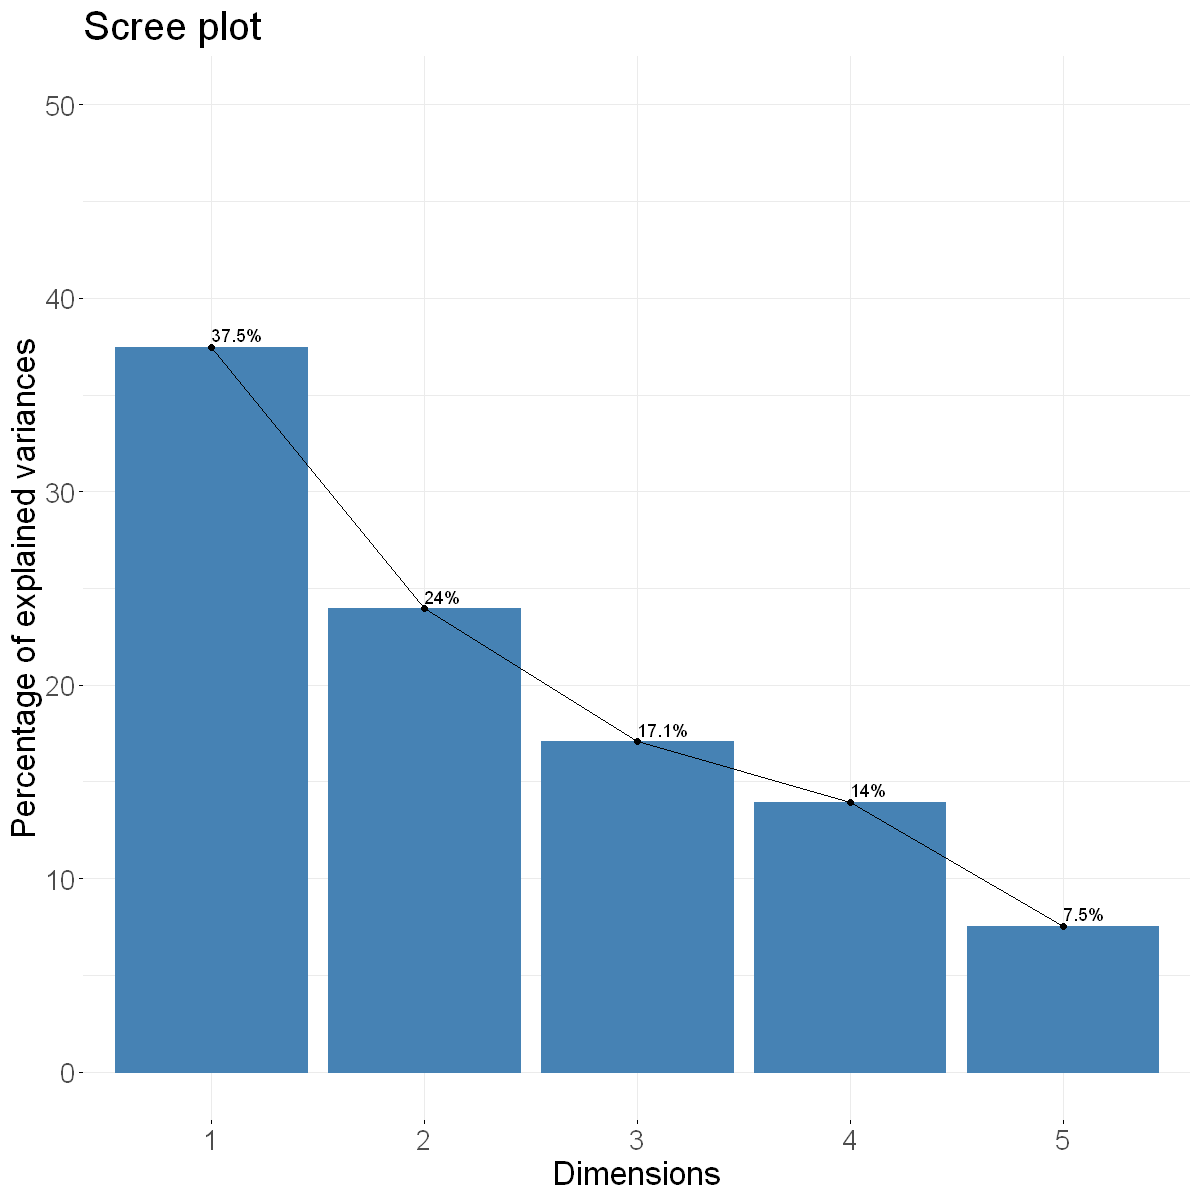

In [23]:
# Parametre sortie graph
options(repr.plot.width=10, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

# Variance par axe
fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50)) + theme_format

### 4.4 Graphe des variables sur plan principal ACP

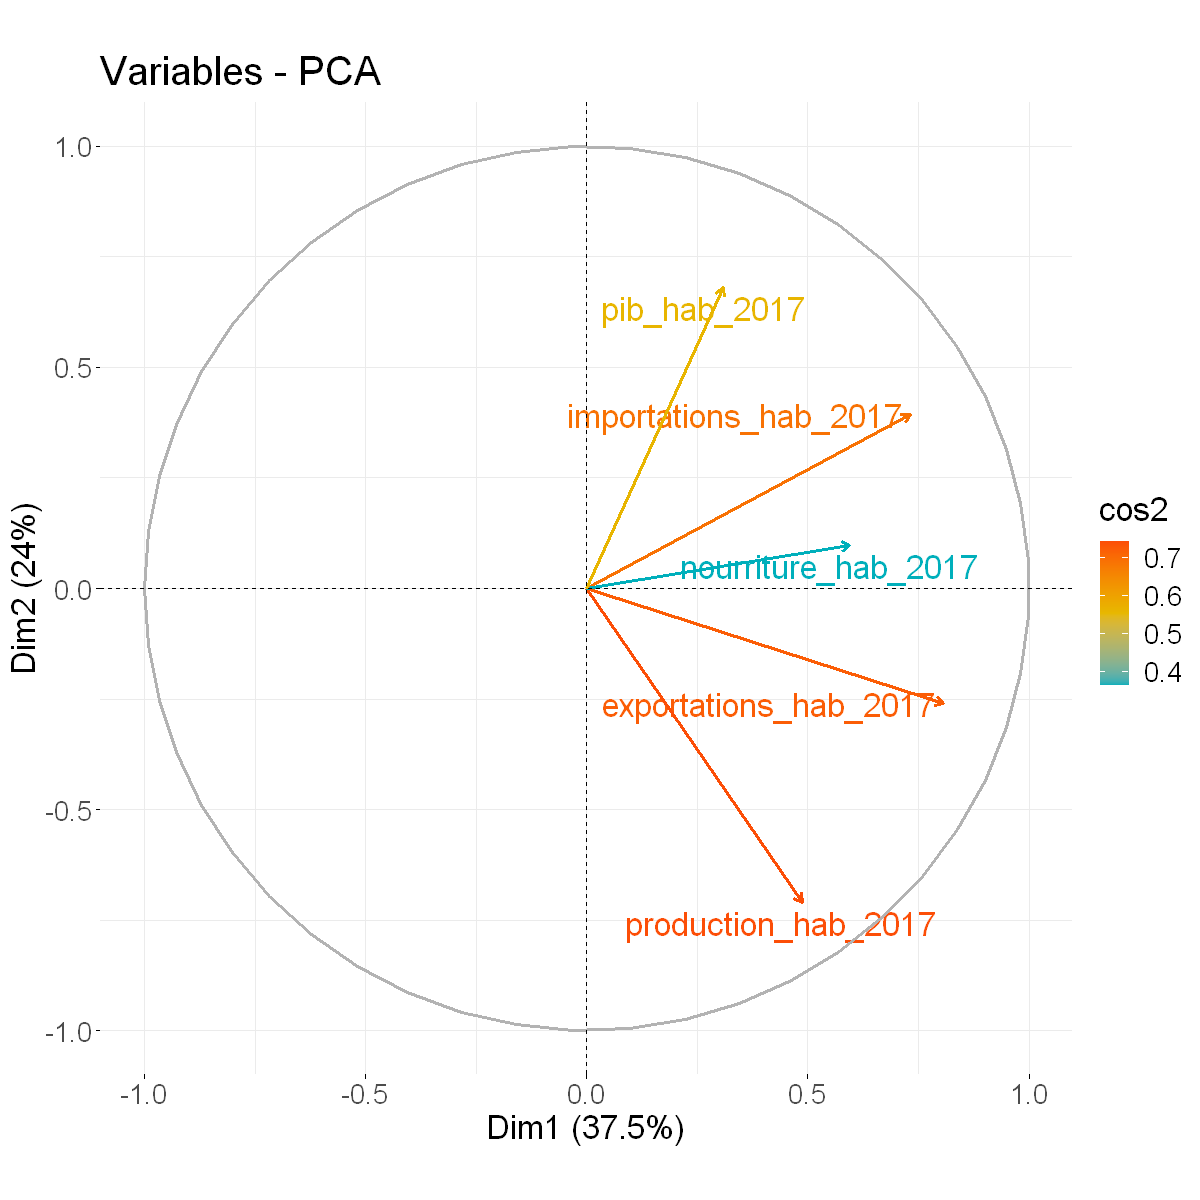

In [24]:
# Parametre sortie graph
options(repr.plot.width=10, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

# Colorer en fonction du cos2: qualité de représentation
var1 <- fviz_pca_var(res.pca, axes=c(1,2), col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE, # Évite le chevauchement de texte
             invisible=c("quanti.sup"), labelsize=7, pointsize=15, arrowsize=1, circlesize=1
             )  + theme_format

var1

### Tableau des corrélation variables / axes ACP

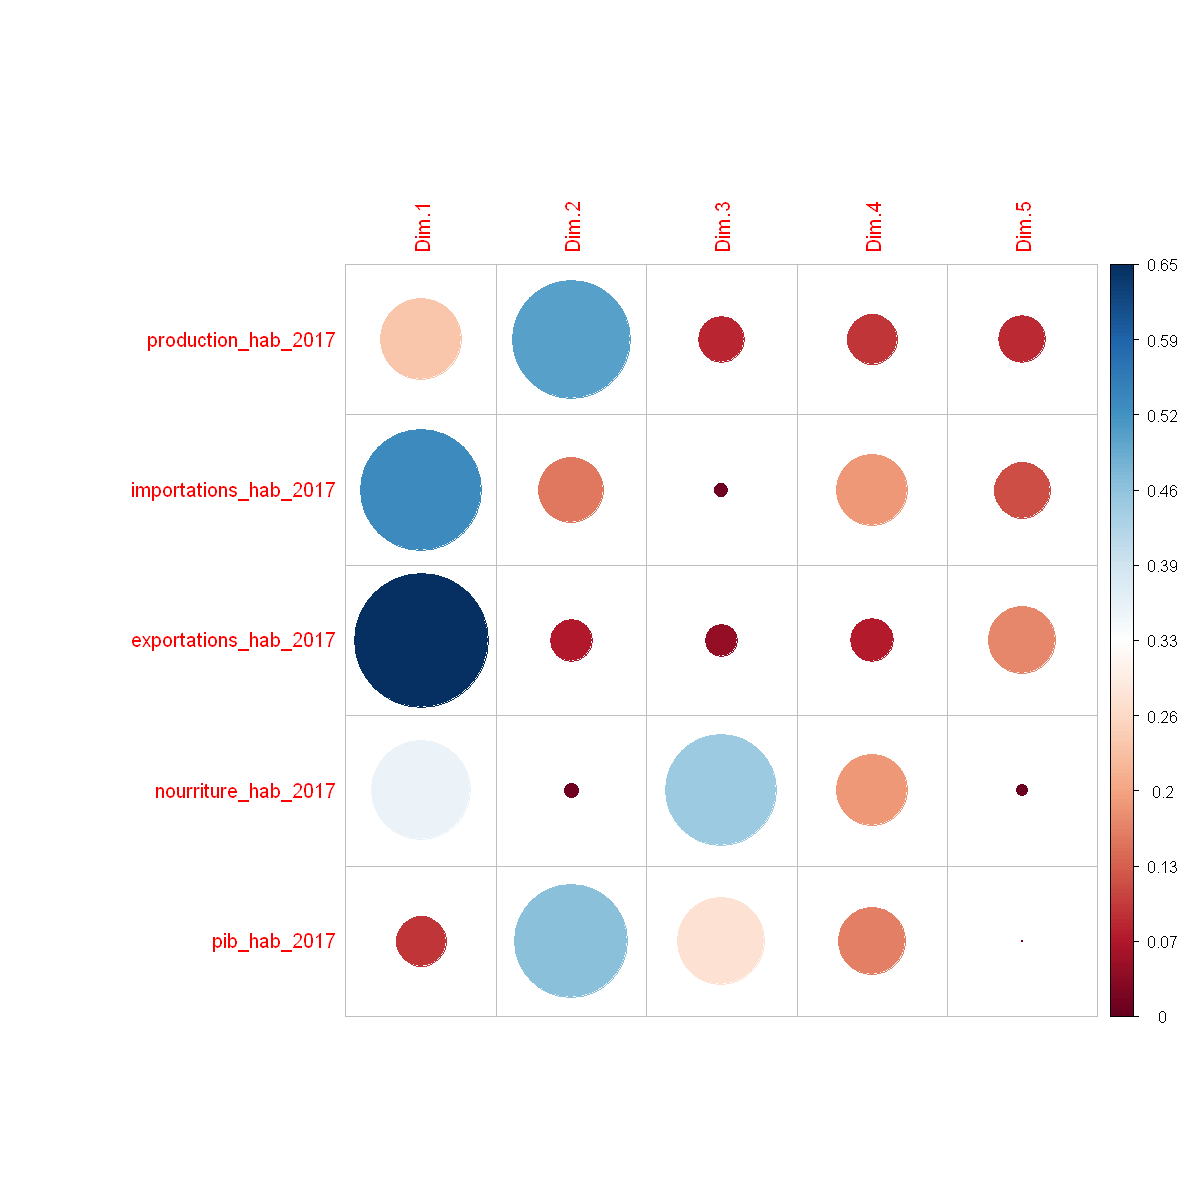

In [25]:
# Parametre sortie graph
options(repr.plot.width=10, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

#Tableau des corrélations entre les axes de l'ACP et les variables
corrplot(var$cos2, is.corr=FALSE)

### 4.5 Graphe des pays sur plan principal ACP

Warning message:
"ggrepel: 147 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


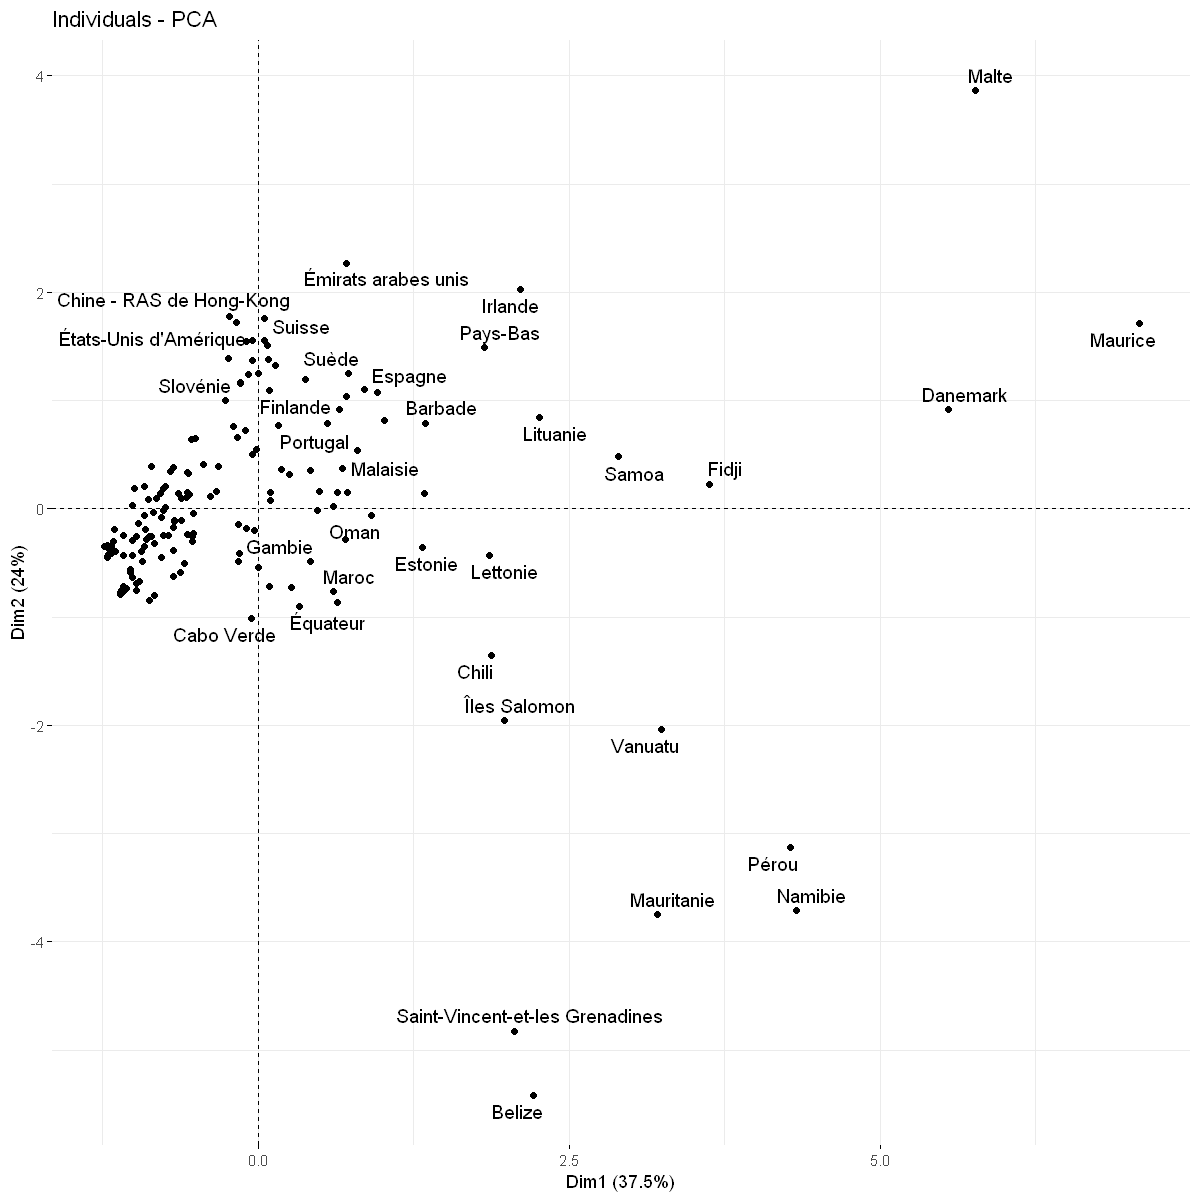

In [26]:
# Parametre sortie graph
options(repr.plot.width=10, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

#Graphe des individus avec affichage des individus les mieux projetés sur les 2 axes
#options(ggrepel.max.overlaps=100)
ind1 <- fviz_pca_ind(res.pca, repel=TRUE)
ind1

### Variables et pays sur même graphique

Warning message:
"ggrepel: 152 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


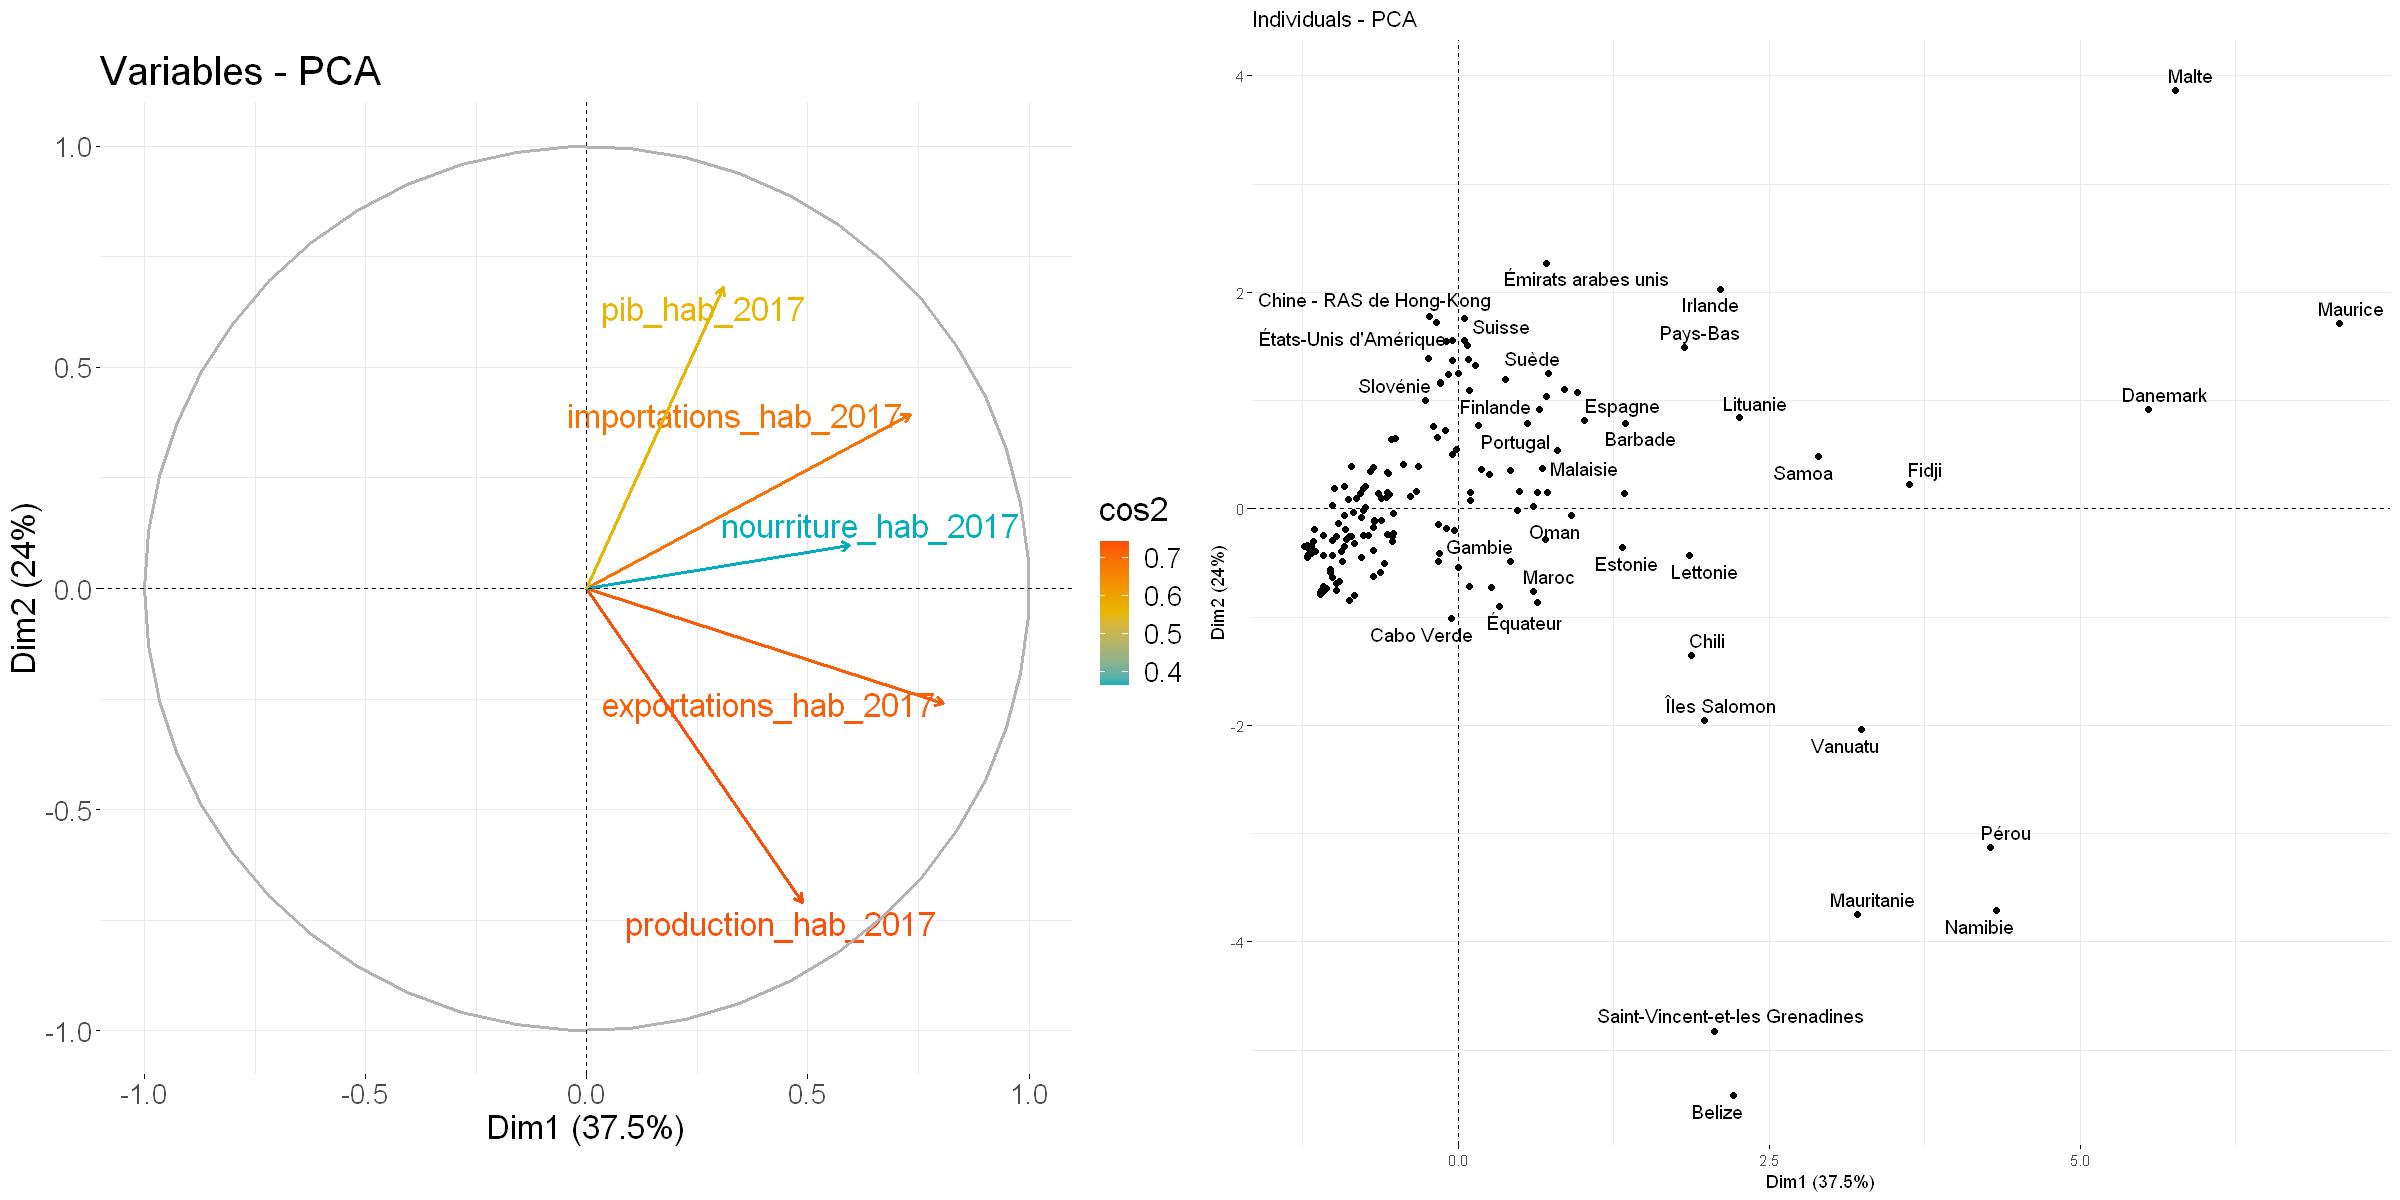

In [27]:
# Parametre sortie graph
options(repr.plot.width=20, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

grid.arrange(var1, ind1, ncol=2, nrow=1)

## 5. Classification hierarchique

In [28]:
# Calcul de la classification hiérarchique en composantes principales
n_clust <- 6

res.hcpc <- HCPC(res.pca, nb.clust = n_clust, graph = FALSE) 

### 5.1 Gains d'inertie

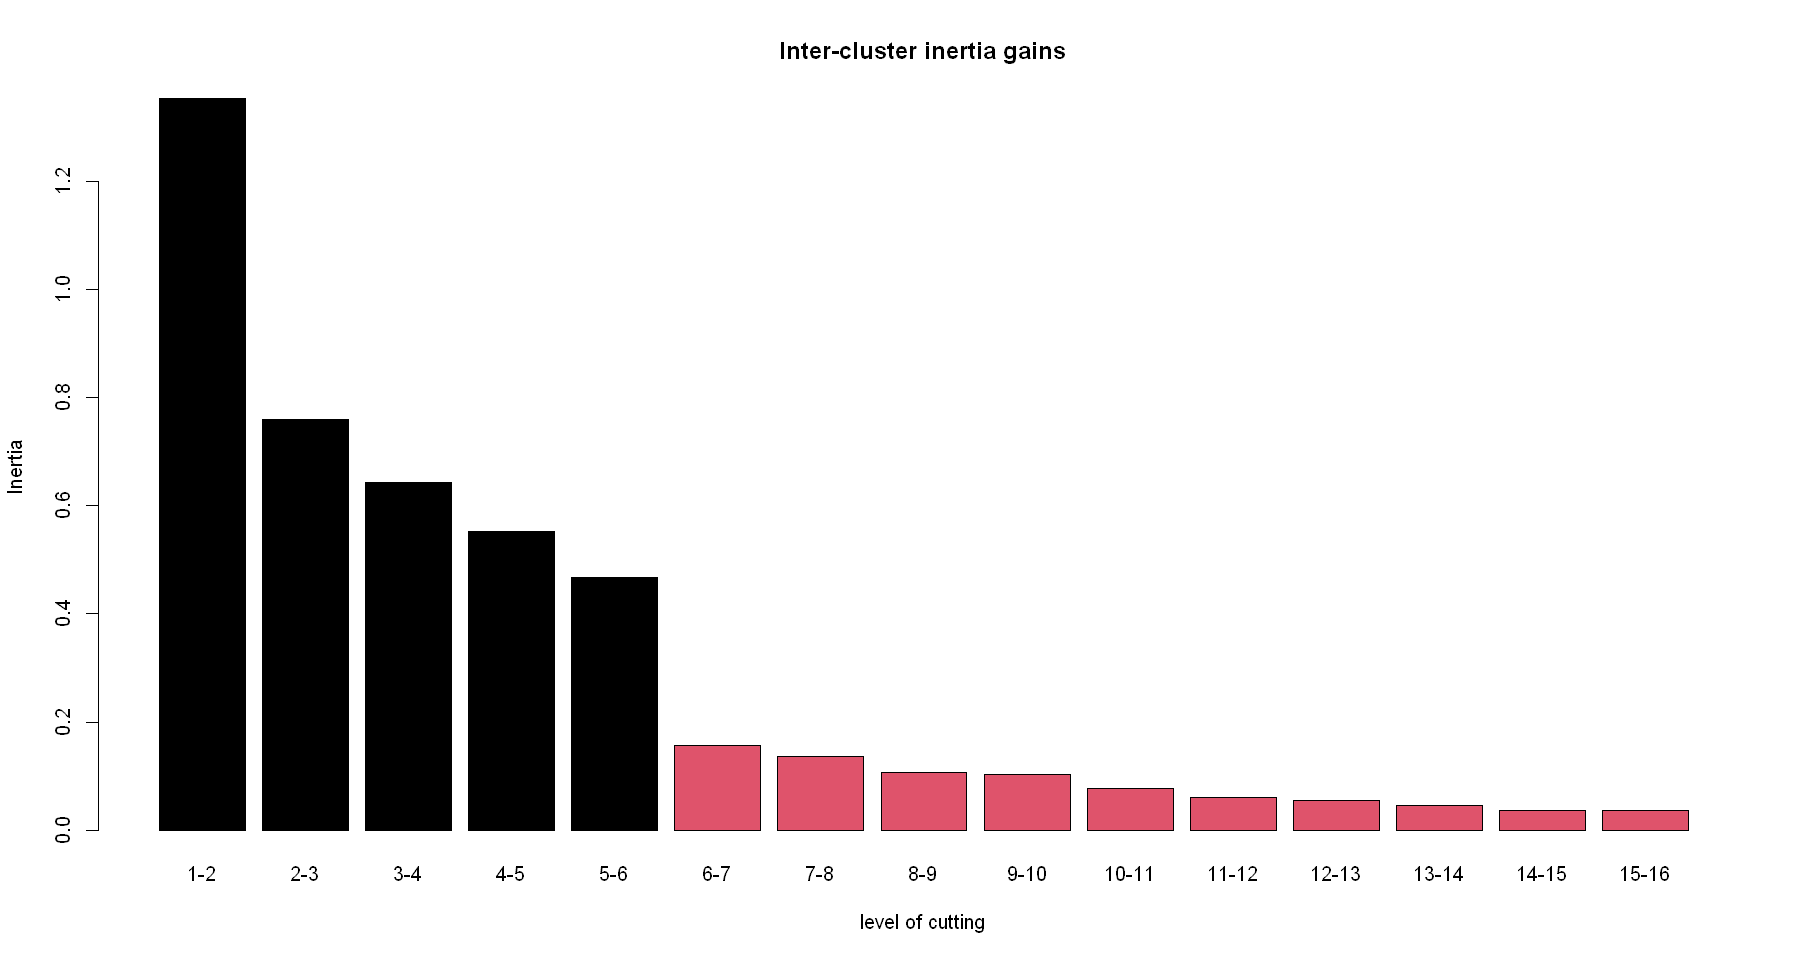

In [29]:
# Parametre sortie graph
options(repr.plot.width=15, repr.plot.height=8)

# Affichage des gain d'inertie inter-classse lors de l'ajout d'une classe
plot(x=res.hcpc, choice="bar")

### 5.2 Dendogramme et niveau de coupe

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


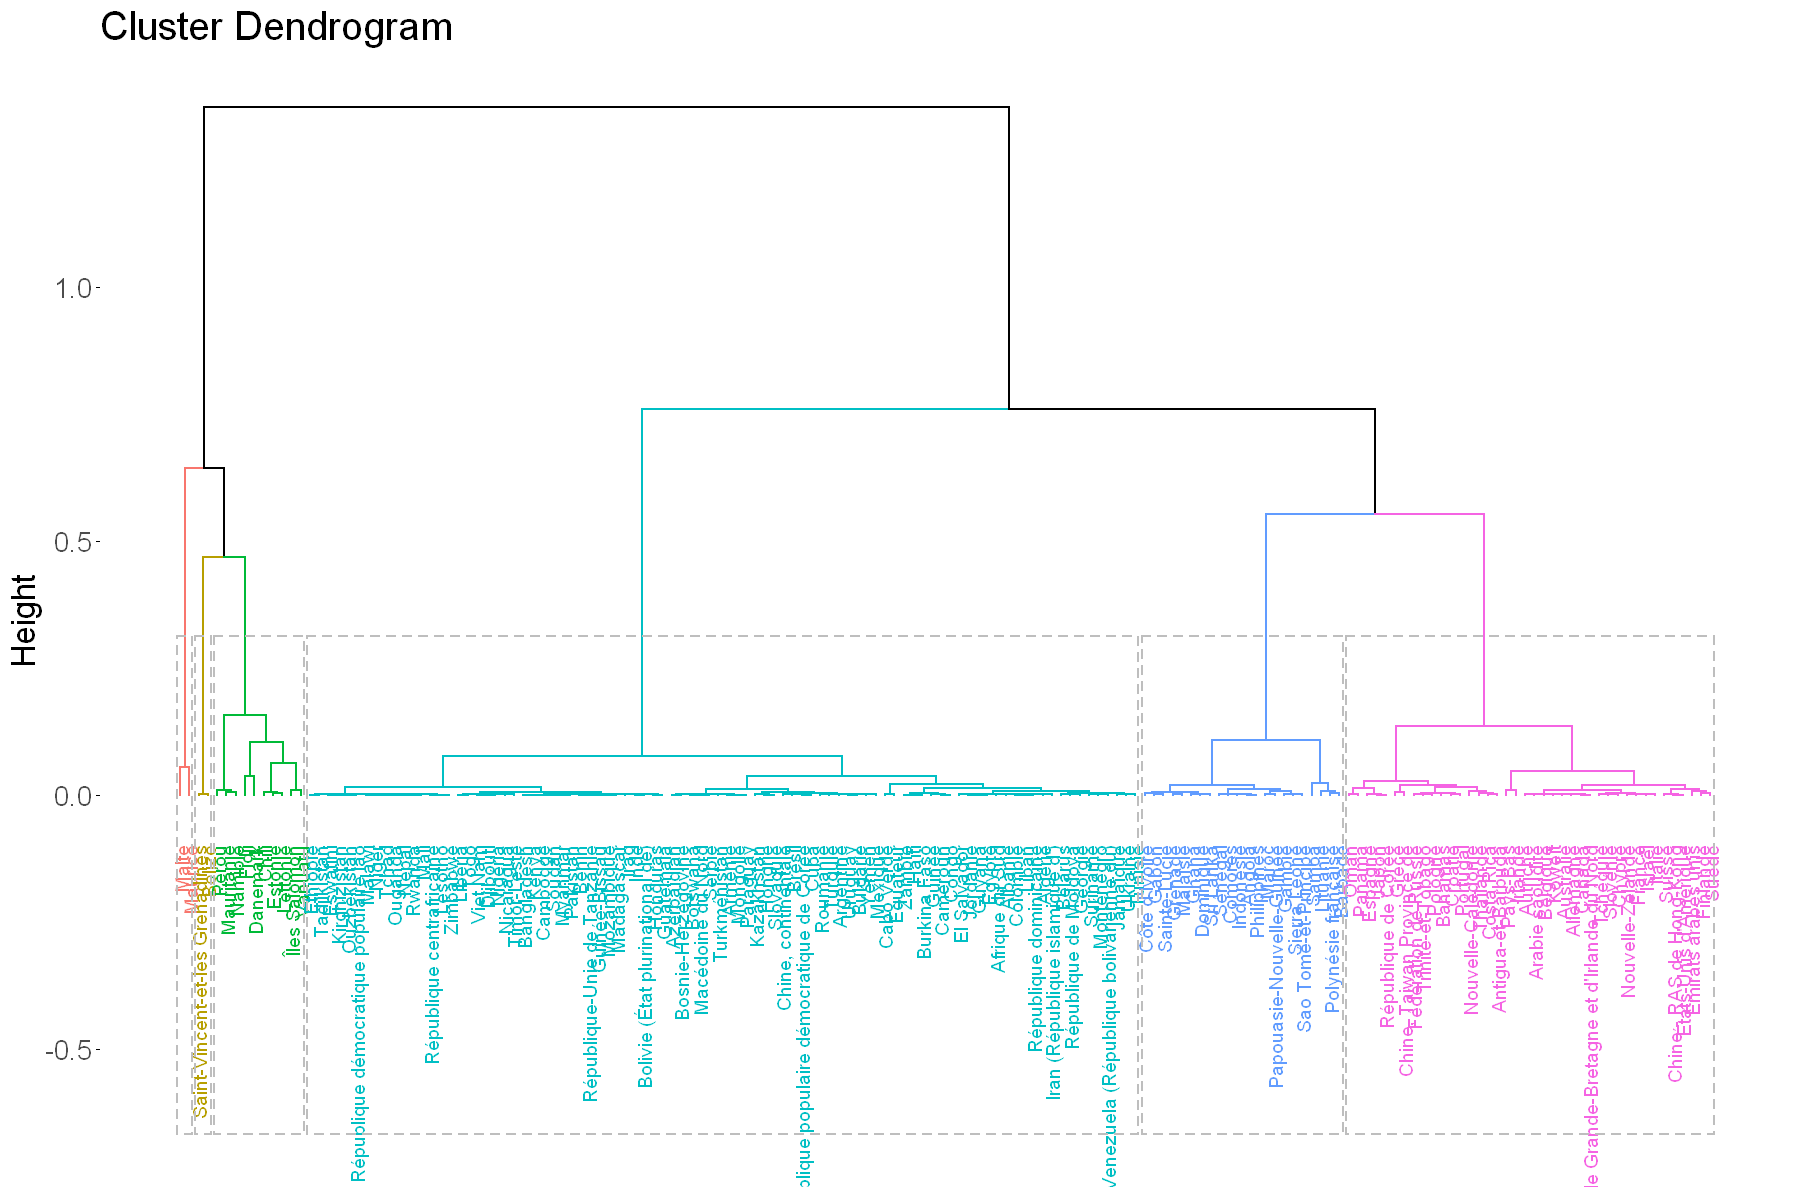

In [30]:
# Parametre sortie graph
options(repr.plot.width=15, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

fviz_dend(res.hcpc, rect=TRUE) + theme_format

### 5.3 Projection du résultat de classification sur plan ACP

In [31]:
# Calcul PCA avec centrage-réduction des données avec la variable cluster en plus
quali_pos = dim(res.hcpc$data.clust)[2]
res.pca2 <- PCA(res.hcpc$data.clust, scale.unit=TRUE, graph = FALSE, ncp=Inf, quali.sup=quali_pos)

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Warning message:
"ggrepel: 149 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


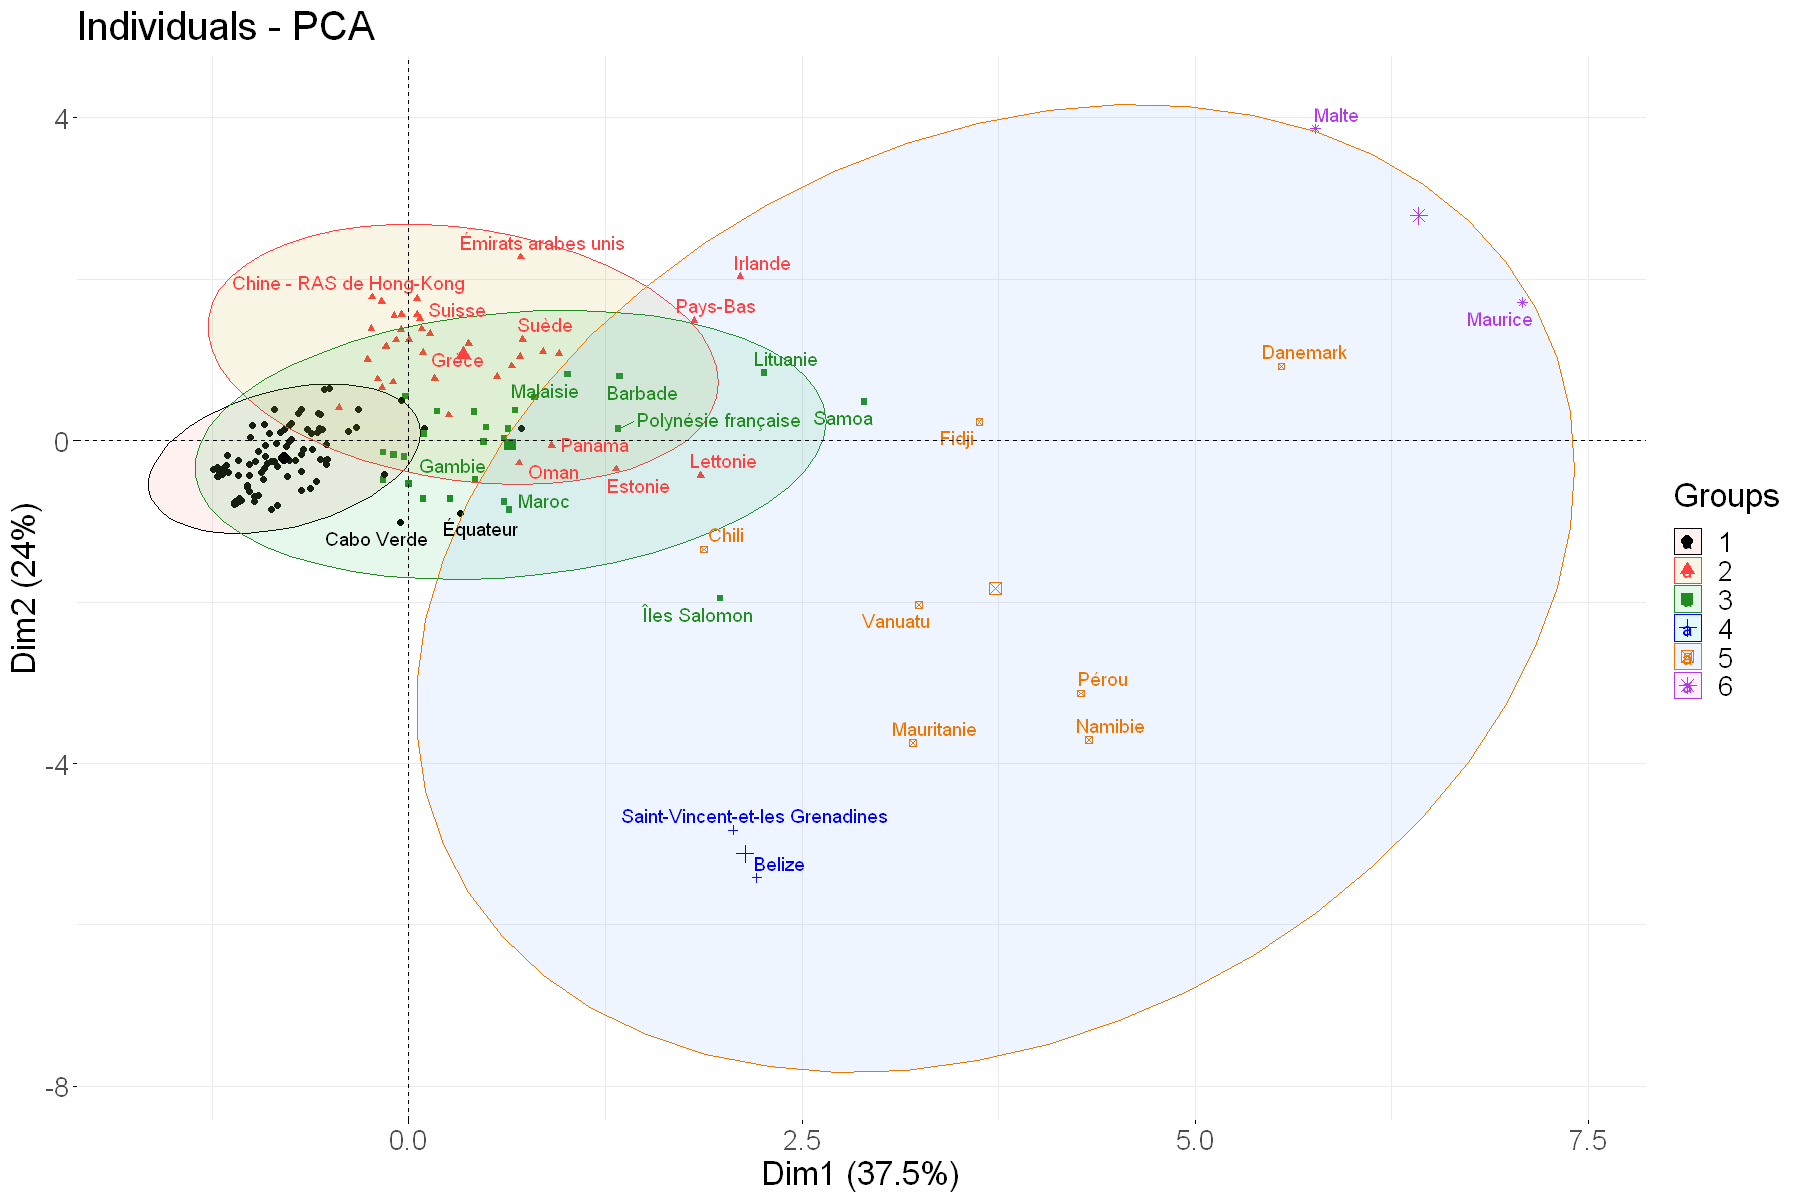

In [32]:
#Affichage des pays avec appartenance aux groupes et les centres de gravité
couleurs <- c("black","brown1","forestgreen","blue","darkorange2", "darkorchid2", "gray")
groupes <- res.hcpc$data.clust$clust

## Parametre sortie graph
options(repr.plot.width=15, repr.plot.height=10)
theme_format <- theme(text=element_text(size=20))

fviz_pca_ind(res.pca2, repel=TRUE, habillage=groupes, addEllipses=TRUE) +
    theme_format + scale_color_manual(values=couleurs)

In [33]:
# pour evaluer temps de calcul
end_time <- Sys.time()
end_time - start_time

Time difference of 15.3755 secs

## 6. Analyse des résutats de l'ACP et la CAH
### 6.1 Problèmes
- Variables importations et exportations sur le même axe (corrélation ?)
- Classification finale non concluante : principaux groupes qui se chevauchent (centres de gravité trop proches)
- Outliers résiduels malgré le filtrage initial
- Autres : ?

### 6.2 Solutions possibles :
- Manque de dissociation entre importations et exportations sur les axes ACP $\Rightarrow$ créations de variables plus spécifiques (ex. ratios..) à la problématique **(features engineering)**
- Nombreux outliers dans le jeu de données $\Rightarrow$ Transformation de variables pour une meilleure compatiblité avec les modèles **(preprocessing)**
- Autres : ?

**feature engineering** : création de variables (caractéristiques) pour que l'information du jeu de données soit exploitable pour le modèle. (ex: texte, images..)


### 6.3 Pistes améliorations :
- Création de nouvelles variables pour améliorer la classification : **boucles entre features engineering $\Longleftrightarrow$ modélisation**
- Rendre l'analyse **ACP dynamique** en incluant la temporalité, avec création d'invidus sous forme de paires **(pays, année)**, permet de voir l'évolution d'un pays sur plan principal 
- Possibilité de spécialiser les axes ACP via des **ACP intermédiaires** propre à un domaine (démographie, économie, développement, envirronemental, ..) puis ACP finale sur un ou plusieurs axes de chaque ACP, cette approche permet de prendre plus de variables au départ
- Autres : ?